# T1.5 Ejemplo de aplicación en IA: clasificación de dígitos manuscritos

NumPy es la librería por excelencia en Python para realizar operaciones matriciales de forma eficiente en tareas de Aprendizaje Automático (Machine Learning). 

A continuación, implementaremos un sistema de reconocimiento de imágenes de dígitos manuscritos (del 0 al 9) utilizando un modelo de **Regresión Logística**.

Pero antes de nada, instalaremos las librerías necesarias:

In [1]:
#!pip install seaborn scikit-learn pandas pillow gradio matplotlib # esto solo es necesario ejecutarlo una vez, descomentar línea y ejecutar en caso necesario.

### 5.1. El conjunto de datos (Corpus Digits)

Utilizaremos el dataset `digits` de la librería `sklearn`, que contiene $N=1797$ imágenes de dígitos manuscritos de $D=8\times8=64$ píxeles.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split

# Cargar datos
digits = load_digits()
# X es la matriz de muestras NxD
X = digits.images.astype(np.float16).reshape(-1, 64) # Aplanamos 8x8 a 64
X /= X.max() # Normalizamos nivel de grises de los píxeles a [0, 1]
# y es el vector de etiquetas de clase
y = digits.target

print(f"Dimensiones X: {X.shape}")
print(f"Dimensiones y: {y.shape}")
print(f"N = {X.shape[0]}")
print(f"D = {X.shape[1]}")
print(f"C = {len(np.unique(y))}")


Dimensiones X: (1797, 64)
Dimensiones y: (1797,)
N = 1797
D = 64
C = 10


**Visualización del corpus**

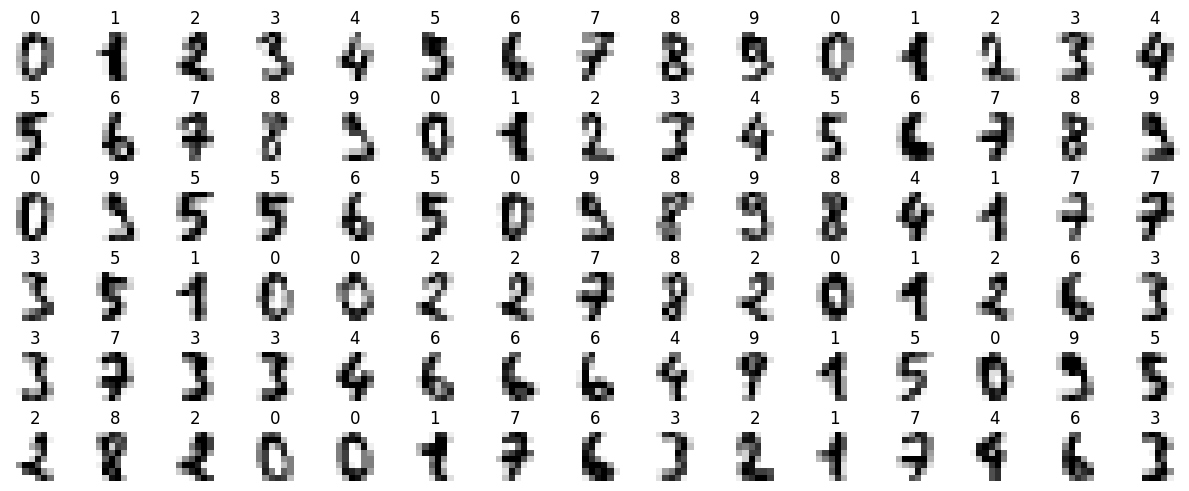

In [3]:
nrows = 6; ncols = 15
_, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12*nrows/ncols), constrained_layout=True)
for ax, xn, yn in zip(axs.flat, X, y):
  ax.set_axis_off(); image = xn.reshape(8, 8); ax.set_title(yn)
  ax.imshow(image, cmap=plt.cm.gray_r, interpolation="none")

### 5.2. Modelo de Regresión Logística

El modelo se basa en calcular la probabilidad de que una muestra $\boldsymbol{x}$ representada por $D$ características (dimensiones) pertenezca a cada una de las clases $c \in \{1, \ldots, C\}$ de un total de $C$ clases distintas.

Para el caso de la tarea Digits:
- Una muestra $\boldsymbol{x}$ es una imagen, la cual lleva asociada una etiqueta de clase $y$.
- Cada imagen (muestra) es representada por un vector de $8 \times 8$ píxeles ($D=64$).
- Cada píxel (característica) exhibe un valor entre 0 y 1 correspondiente al nivel de gris. 
- Hay $C=10$ clases distintas, cuyas etiquetas de clase son $\boldsymbol{y} \in \{0, 1, 2, ..., 9\}$.

Esto se realiza mediante la función **Softmax** $\mathcal{S}$ aplicada sobre el vector de logits $\boldsymbol{a}$, que se define como el producto escalar entre la matriz de pesos $\mathbf{W}$ (parámetros) del modelo y la muestra $\boldsymbol{x}$. El modelo seleccionará (asignará) la clase $c$ con mayor probabilidad $\boldsymbol{\mu}_c$.

$$c(\boldsymbol{x})%
=\operatorname*{argmax}\limits_c\;\boldsymbol{\mu}_c%
\quad\text{con}\quad%
\boldsymbol{\mu}_c=\mathcal{S}(\boldsymbol{a})_c,\quad%
\boldsymbol{a}=f(\boldsymbol{x};\mathbf{W})=\mathbf{W}^t\boldsymbol{x},\quad%
\mathbf{W}\in\mathbb{R}^{D\times C}\quad\text{y}\quad\boldsymbol{x}\in\mathbb{R}^D$$

Para entrenar los parámetros $\mathbf{W}$ del modelo, usaremos un conjunto de $N$ muestras de aprendizaje etiquetadas $(\boldsymbol{x}_n, \boldsymbol{y}_n)$ tales que minimicen la **Negative Log-Likelihood (NLL)**:

$$\operatorname{NLL}(\mathbf{W})%
=\frac{1}{N}\sum_{n=1}^N-\log p(\boldsymbol{y}_n\mid\boldsymbol{\mu}_n)$$

Para ello se aplicará el algoritmo de **Descenso por Gradiente**:

$$\displaystyle\quad\mathbf{W}_0=\mathbf{0};\quad\mathbf{W}_{i+1}=\mathbf{W}_i -\eta_i\frac{\partial\operatorname{NLL}}{\partial\mathbf{W}^t}\biggr\vert_{\mathbf{W}_i}\quad i=0,1,\ldots$$

Donde el gradiente es:

$$\begin{pmatrix}%
\frac{\partial\operatorname{NLL}}{\partial W_{11}}&\cdots&\frac{\partial\operatorname{NLL}}{\partial W_{1C}}\\%
\vdots&\ddots&\vdots\\%
\frac{\partial\operatorname{NLL}}{\partial W_{D1}}&\cdots&\frac{\partial\operatorname{NLL}}{\partial W_{DC}}\\%
\end{pmatrix}
=\frac{\partial\operatorname{NLL}}{\partial\mathbf{W}^t}%
=\frac{1}{N}\sum_{n=1}^N\frac{\partial(-\log p(\boldsymbol{y}_n\mid\boldsymbol{\mu}_n))}{\partial \mathbf{W}^t}%
=\frac{1}{N}\sum_{n=1}^N\boldsymbol{x}_n(\boldsymbol{\mu}_n-\boldsymbol{y}_n)^t$$

In [4]:
# Convierte una etiqueta de clase en un vector de one-hot encoding
def OneHotEncoding(y):
    C = np.unique(y).size
    return np.eye(C)[y]

# Calcula el gradiente de la NLL
def ComputeGradient(X, Y_onehot, W):
    N = X.shape[0]
    # 1. Calcular logits (a)
    a = X @ W
    # 2. Estabilidad numérica: restar el máximo
    a -= a.max(axis=1, keepdims=True)
    # 3. Softmax (mu)
    mu = np.exp(a)
    mu /= np.sum(mu, axis=1, keepdims=True)
    # 4. Gradiente
    Z = mu - Y_onehot
    return (X.T @ Z) / N

# Algoritmo de descenso por gradiente
def LogisticRegressionTraining(X, y, maxEpochs=100, eta=0.1):
    N, D = X.shape
    C = np.unique(y).size
    W = np.zeros((D, C))
    Y_onehot = OneHotEncoding(y)
    
    for epoch in range(maxEpochs):
        grad = ComputeGradient(X, Y_onehot, W)
        W = W - eta * grad
        
    return W

# Clasificación 
## Nota: como solo queremos devolver la decisión (etiqueta), no es necesario calcular la Softmax
def LogisticRegressionClassification(X, W):
    a = X @ W
    return np.argmax(a, axis=1)

### 5.3. Entrenamiento y Evaluación

Dividimos los datos en entrenamiento (80%) y test (20%). Entrenamos y calculamos el error de predicción tanto en train como en test, si bien el error de test es el que realmente nos interesa.

In [5]:
# Partición: 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=42)

print(f"Entrenando con {X_train.shape[0]} muestras...")

# Entrenamiento
W_trained = LogisticRegressionTraining(X_train, y_train, maxEpochs=50, eta=0.1)

# Evaluación
## train
print(f"Clasificando las {X_train.shape[0]} muestras de train...")
predictions_train = LogisticRegressionClassification(X_train, W_trained)
accuracy_train = np.mean(predictions_train == y_train)
error_rate_train = 1.0 - accuracy_train
print(f"- Tasa de error en train: {error_rate_train:.1%}")
## test
print(f"Clasificando las {X_test.shape[0]} muestras de test...")
predictions_test = LogisticRegressionClassification(X_test, W_trained)
accuracy_test = np.mean(predictions_test == y_test)
error_rate_test = 1.0 - accuracy_test


print(f"- Tasa de error en test: {error_rate_test:.1%}")

Entrenando con 1437 muestras...
Clasificando las 1437 muestras de train...
- Tasa de error en train: 11.2%
Clasificando las 360 muestras de test...
- Tasa de error en test: 11.4%


### 5.4. Visualización de predicciones

Mostramos algunas muestras del conjunto de test con su predicción y la etiqueta de clase correcta.

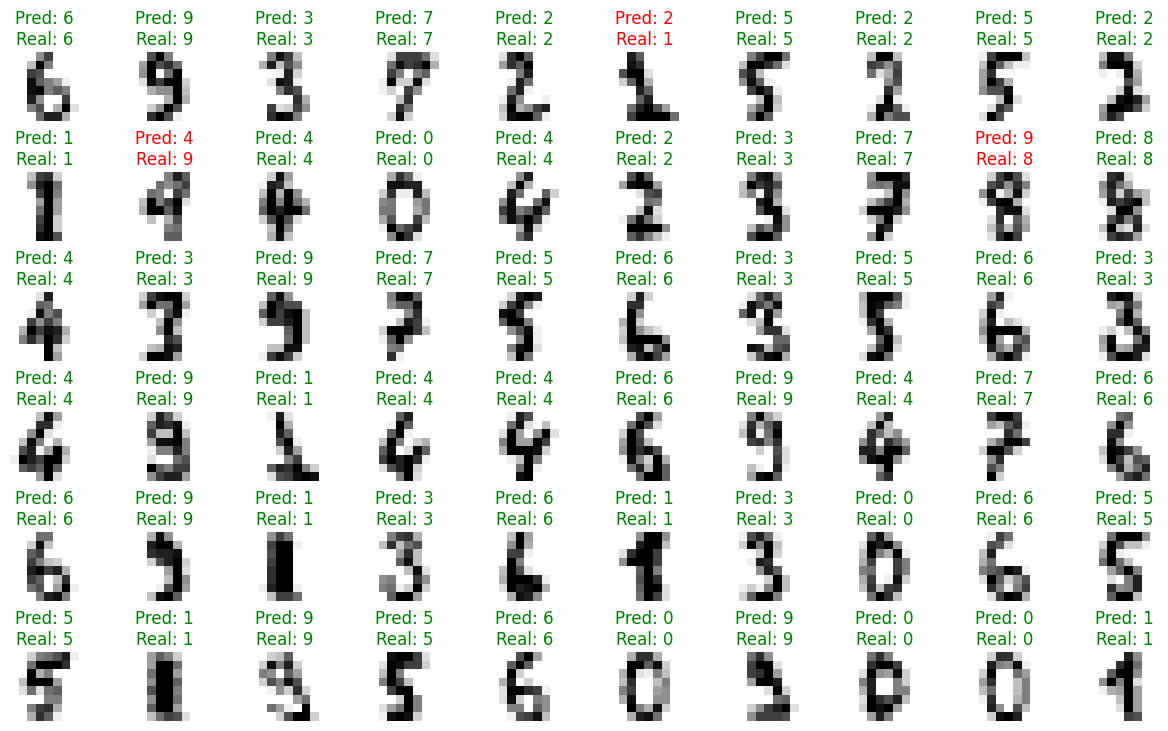

In [6]:
nrows = 6; ncols = 10
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 12*nrows/ncols), constrained_layout=True)

for i, ax in enumerate(axs.flat):
    ax.axis('off')
    # Reshape de 64 a 8x8 para visualizar
    img = X_test[i].reshape(8, 8)
    ax.imshow(img, cmap=plt.cm.gray_r)
    
    pred_label = predictions_test[i]
    true_label = y_test[i]
    
    color = 'green' if pred_label == true_label else 'red'
    ax.set_title(f"Pred: {pred_label}\nReal: {true_label}", color=color)